Magneto Optical Trap (MOT)

In [72]:
#Import necessary packages 
# %matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import sympy as sym
import scipy as sp
from scipy import constants as cons
from scipy import stats
from scipy.stats import multivariate_normal
mpl.rc('text', usetex = True)
mpl.rc('font', family = 'serif')
from matplotlib import cm
from matplotlib.ticker import LinearLocator



In [73]:
#Figure Settings 
SMALL_SIZE = 14
MEDIUM_SIZE = 14
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [74]:
#Rubidium 87 parameters

mass_u = cons.value("atomic mass constant")
mass_rb85 = 84.9118 * mass_u #Kg
mass_rb87 = 86.9091 * mass_u #Kg
mass_na23 = 22.9898 * mass_u #Kg
collision_cs = 2e-17 # (m2) # Collision cross-section for RB atoms

# D2 Line Optical Properties

lifetime_d2rb87 = 2.624e-8 # (ns) Excited state lifetime of Rb87
decay_d2rb87 = (1/lifetime_d2rb87) # (s-1) Natural line width
decay_atomic = decay_d2rb87/(2*np.pi)
atom_frequency_d2rb87 = 384.2304844e12 # Hz (*2*pi for w0)

# D1 Line Optical Properties

lifetime_d1rb87 = 2.770e-8 #excited state lifetime of Rb87 (ns)
decay_d1rb87 = (1/lifetime_d1rb87) / (2*cons.pi) #(s-1) Natural line width
atom_frequency_d1rb87 = 377.1074635e12 # Hz (*2*pi for w0)

In [75]:
#Beam Parameters
detuning =  8e6 *2*cons.pi
freq_laser =  atom_frequency_d2rb87 - detuning #Hz - Calculated from a red-shifted detuning
beam_intensity = 10 # (W/m2) Beam intensity
wavenumber = (2* cons.pi * freq_laser) / cons.c  #m-1 Wave number of the trapping light k
wavelength = cons.c / freq_laser
beam_radious = 0.01 # metres (2cm diameter beam)
dipole_moment_polarised = 2.534e-29 #(C*m) Dipole moment for F = 2 to F' = 3 transition pol light
beams = 6 # Number of total beams (6 beam MOT)

#Trap Parameters
area = 4*cons.pi*beam_radious**2  # Surface area of overlap volume
volume = (4/3)*cons.pi*beam_radious**3 # Overlap Volume Sphere 
volume_steinmetz = 8 * (2 - np.sqrt(2)) * beam_radious**3
background_temp = 293 # Background temperature (K)
velocity_rms = np.sqrt((2 * cons.k * background_temp)/(mass_rb87)) #Root mean squared velocity background gas (m/s)

#Saturation intensity RB87 D2 Line (W/m2)
sat_intensity = (cons.hbar * (2*cons.pi*atom_frequency_d2rb87)**3 * decay_d2rb87) / (12*cons.pi* cons.c **2)
v_thermal = np.sqrt((8*cons.k * background_temp)/ (cons.pi * mass_rb87))
no_density = 1e8 #/cm3 backfround gas density 
beta = beam_intensity / sat_intensity # Saturation parameter Ii/Isat

In [76]:
# Magnetic Field Ansatz
mag_field = 10 #Tesla 

#Define cartesian mag field 
x_b = np.linspace(-1, 1, 100)
y_b = np.linspace(-1, 1, 100)
z_b = np.linspace(-1, 1, 100)
B = mag_field * np.array([x_b, y_b, -2*z_b])

#Define cylindrical magnetic field
r_b = np.linspace(-1, 1, 100)
zeta_b = np.linspace(-1, 1, 100)
B_cyl = mag_field * np.array([r_b, -2*z_b])


In [77]:
# Optical Molasses 

vel = np.linspace(-10, 10, 1000) #velocity

absorption = (decay_d2rb87/2) * (beta)/(1 + (beam_intensity*beams/sat_intensity) + (2 * detuning / decay_d2rb87)**2)

forceplus = (0.5 * cons.hbar * wavenumber * decay_d2rb87 * beta) / (1 + (beams*beta) + ((2*(detuning + wavenumber*vel))/(decay_d2rb87))**2 )
forceminus = -(0.5 * cons.hbar * wavenumber * decay_d2rb87 * beta) / (1 + (beams*beta) + ((2*(detuning - wavenumber * vel))/(decay_d2rb87))**2 )
forcetotal = forceplus + forceminus

acceleration = forcetotal/mass_rb87
accelerationplus = forceplus/mass_rb87
accelerationminus = forceminus/mass_rb87

In [78]:
# # Optical Molasses w/ Zeeman Effect
#T is 0
B = 0.1  # T/m - Magnetic gradient of the magnetic field 
gfactor_RB87 = 1/3
mu = cons.value("Bohr magneton") # JOULES PER TESLA J/T
# Have to remove g-factor form mu 
vel = np.linspace(-10, 10, 1000) #velocity

absorption = (decay_d2rb87/2) * (beta)/(1 + (beam_intensity*beams/sat_intensity) + (2 * detuning / decay_d2rb87)**2)

forceplusZ = (0.5 * cons.hbar * wavenumber * decay_d2rb87 * beta) / (1 + (beams*beta) + ((2*(detuning + wavenumber*vel - (mu*B*beam_radious/cons.hbar))/(decay_d2rb87))**2 ))
forceminusZ = -(0.5 * cons.hbar * wavenumber * decay_d2rb87 * beta) / (1 + (beams*beta) + ((2*(detuning - wavenumber * vel + (mu*B*beam_radious/cons.hbar))/(decay_d2rb87))**2 ))
forcetotalZ = forceplusZ + forceminusZ

accelerationZ = forcetotalZ/mass_rb87
accelerationplusZ = forceplusZ/mass_rb87
accelerationminusZ = forceminusZ/mass_rb87

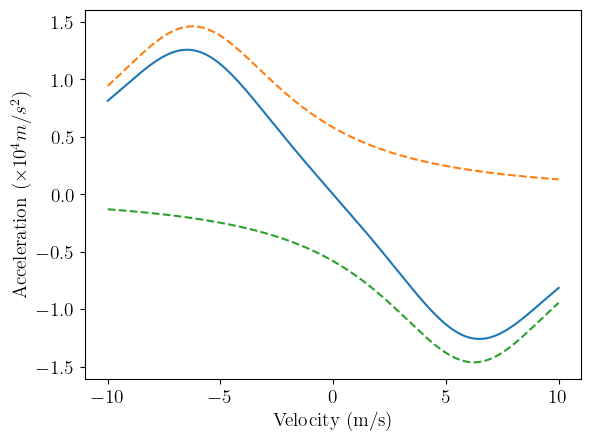

In [79]:
#FIG: Optical Molasses Forces 
plt.figure(1)
plt.plot(vel, acceleration*1e-4, vel, accelerationplus*1e-4,"--", vel, accelerationminus*1e-4,"--")
#plt.title("Optical damping forces vs atom velocity for 1D optical molasses", y=1.05)
plt.xlabel("Velocity (m/s)")
plt.ylabel(r"Acceleration $( \times 10^4 m/s^2)$")
plt.savefig('Figures/Molasses.svg', format='svg')

Text(0, 0.5, 'Force F (N)')

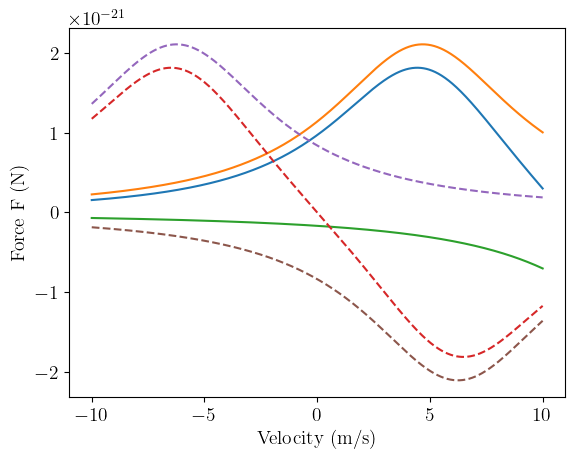

In [80]:
#FIG: Optical Molasses Forces 
plt.figure(1)
plt.plot(vel, forcetotalZ, vel, forceplusZ, vel, forceminusZ, vel, forcetotal,"--", vel, forceplus,"--", vel, forceminus, "--")
#plt.title("Optical damping forces vs atom velocity for 1D optical molasses", y=1.05)
plt.xlabel("Velocity (m/s)")
plt.ylabel("Force F (N)")

Text(0, 0.5, 'Acceleration $( \\times 10^4 m/s^2)$')

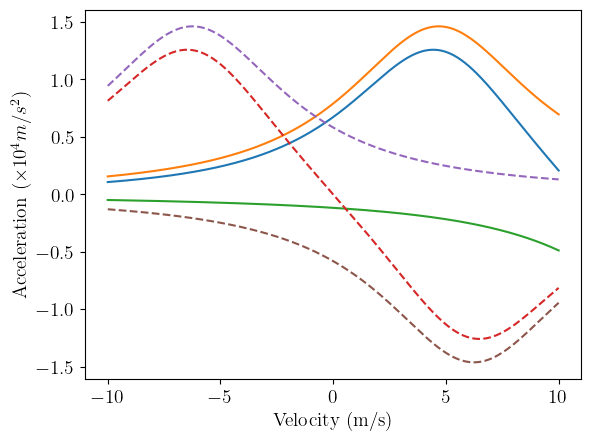

In [81]:
#FIG: Optical Molasses Acceleration
plt.figure(2)
plt.plot(vel, accelerationZ*1e-4, vel, accelerationplusZ*1e-4, vel, accelerationminusZ*1e-4, vel, acceleration*1e-4, "--", vel, accelerationplus*1e-4,"--", vel, accelerationminus*1e-4,"--")
#plt.title("Optical damping acceleration vs atom velocity for 1D optical molasses", y=1.05)
plt.xlabel("Velocity (m/s)")
plt.ylabel(r"Acceleration $( \times 10^4 m/s^2)$")

In [82]:
# Spatial effect of Zeeman effect 
# Set v = 0
vel = 0
x_b = np.linspace(-.01, .01, 1000)

forceplusS = (0.5 * cons.hbar * wavenumber * decay_d2rb87 * beta) / (1 + (beams*beta) + ((2*(+detuning + wavenumber*vel + (mu*B*x_b/cons.hbar))/(decay_d2rb87))**2 ))
forceminusS = -(0.5 * cons.hbar * wavenumber * decay_d2rb87 * beta) / (1 + (beams*beta) + ((2*(+detuning - wavenumber * vel - (mu*B*x_b/cons.hbar))/(decay_d2rb87))**2 ))
forcetotalS = forceplusS + forceminusS

accelerationS = forcetotalS/mass_rb87
accelerationplusS = forceplusS/mass_rb87
accelerationminusS = forceminusS/mass_rb87

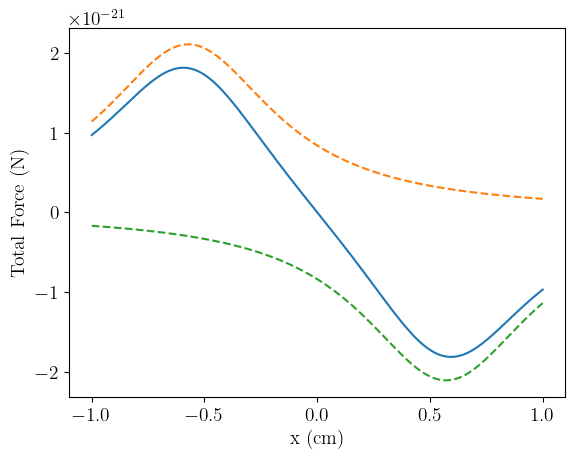

In [83]:
#FIG: Zeeman Effect Forces 
plt.figure(3)
plt.plot(x_b*100, forcetotalS, x_b*100, forceplusS, "--", x_b*100, forceminusS, "--")
#plt.title("Optical damping acceleration vs atom velocity for 1D optical molasses", y=1.05)
plt.xlabel("x (cm)")
plt.ylabel("Total Force (N)")
plt.savefig('Figures/zforces.svg', format='svg')

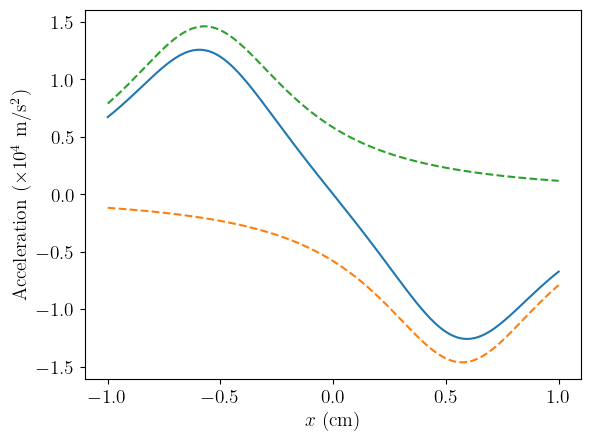

In [84]:
#FIG: Zeeman Effect Acceleration
plt.figure(3)
plt.plot(x_b*100, accelerationS/1e4, x_b*100, accelerationminusS/1e4, "--", x_b*100, accelerationplusS/1e4, "--")
#plt.title("Optical damping acceleration vs atom velocity for 1D optical molasses", y=1.05)
plt.xlabel("$x$ (cm)")
plt.ylabel(r"Acceleration ($\times 10^4$ m/s$^2$)")
plt.savefig('Figures/Zeeman.svg', format='svg')

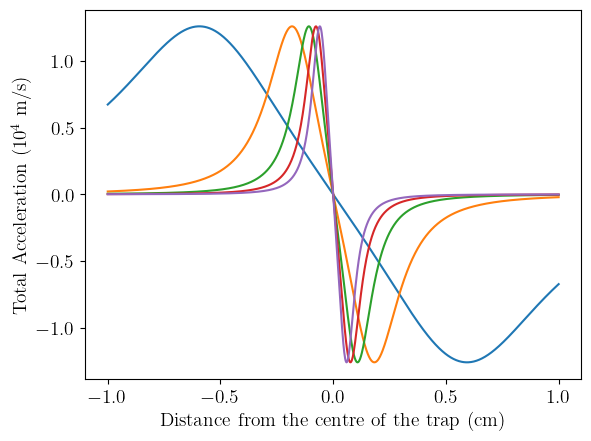

In [85]:
# Spatial effect of Zeeman effect varying B
# Set v = 0
vel = 0
x_bB = np.linspace(-0.01, .01, 1000)
mag_grad = np.linspace(0.1, 1, 5) #T/m2
for i in range(len(mag_grad)):

    forceplusSB = (0.5 * cons.hbar * wavenumber * decay_d2rb87 * beta) / (1 + (beams*beta) + ((2*(detuning + wavenumber*vel + (mu*mag_grad[i]*x_b/cons.hbar))/(decay_d2rb87))**2 ))
    forceminusSB = -(0.5 * cons.hbar * wavenumber * decay_d2rb87 * beta) / (1 + (beams*beta) + ((2*(detuning - wavenumber * vel - (mu*mag_grad[i]*x_b/cons.hbar))/(decay_d2rb87))**2 ))
    forcetotalSB = forceplusSB + forceminusSB

    accelerationSB = forcetotalSB/mass_rb87
    accelerationplusSB = forceplusSB/mass_rb87
    accelerationminusSB = forceminusSB/mass_rb87
    plt.figure(3)
    plt.plot(x_bB*100, accelerationSB/1e4)
#plt.title("Optical damping acceleration vs atom velocity for 1D optical molasses", y=1.05)
    plt.xlabel("Distance from the centre of the trap (cm)")
    plt.ylabel("Total Acceleration ($10^4$ m/s)")

In [86]:
B = -0.1
#Spacial effect of Zeeman Effect in 2D 
vel = 0
x_2D = np.linspace(-.01, .01, 100)
z_2D = np.linspace(-.01, .01, 100)
X_2D, Z_2D = np.meshgrid(x_2D, z_2D)


# distance = np.sqrt(X_2D**2+4*Z_2D**2)
distance = np.sqrt(X_2D**2+4*Z_2D**2)
forceplusS_2D = (0.5 * cons.hbar * wavenumber * decay_d2rb87 * beta) / (1 + (beams*beta) + ((2*(+detuning + (mu*B*distance/cons.hbar))/(decay_d2rb87))**2 ))
forceminusS_2D = -(0.5 * cons.hbar * wavenumber * decay_d2rb87 * beta) / (1 + (beams*beta) + ((2*(detuning - (mu*B*distance/cons.hbar))/(decay_d2rb87))**2 ))
forcetotalS_2D = forceplusS_2D + forceminusS_2D

accelerationS_2D = forcetotalS_2D/mass_rb87
accelerationplusS_2D = forceplusS_2D/mass_rb87
accelerationminusS_2D = forceminusS_2D/mass_rb87
atot = accelerationplusS_2D + accelerationminusS_2D


Integral Function $dx = \frac{v}{a(v)} dv $

In [87]:
B = 0.1#T/m
# Numerical Integration Optical Molasses 
v = np.linspace(0, 20, 1000)
def dx(vA, detuning, beam_intensity):
    res = lambda vA: vA/((cons.hbar * wavenumber * decay_d2rb87 * 0.5)/(mass_rb87) * (((beam_intensity / sat_intensity)/(1 + beams*(beam_intensity / sat_intensity) + ((2*detuning - 2* wavenumber * vA)/decay_d2rb87)**2)) - (((beam_intensity / sat_intensity)/(1 + beams*(beam_intensity / sat_intensity) + ((2*detuning + 2* wavenumber * vA)/decay_d2rb87)**2)))))
    lit = np.zeros_like(vA)
    for i, val in enumerate(vA):
        y, err = sp.integrate.quad(res, 1, val)
        lit[i] = y
    return lit
result = np.array([])

(0.0, 2.0)

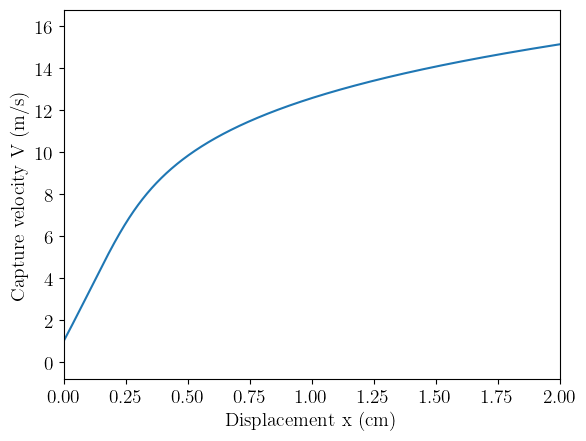

In [88]:
# Plot of distance vs capture velocity (no mag field)
v = np.linspace(0, 16, 1000)
plt.plot(dx(v, 8e6*2*cons.pi, 10)*100,v)
plt.ylabel("Capture velocity V (m/s)")
plt.xlabel("Displacement x (cm)")
# plt.title("Capture velocity v_c (m/s) vs Distance X (cm)")
plt.xlim(0, 2)

ODE Time-dependent Acceleration Function $ \frac{da}{dt} $


In [89]:
# Time-dependent ODE Function
# Negative Acceleration 
# Parameters: Intensity, Detuning and Magnetic Gradient
def dadt(x, S, beam_intensity, detuning, B):
    x, v = S
    return [v,
           -((cons.hbar * wavenumber * decay_d2rb87 * (beam_intensity / sat_intensity))/(2*mass_rb87) * (((1)/(1 + beams*(beam_intensity / sat_intensity) + 4*((detuning - wavenumber * v - (mu*B*x/cons.hbar))/decay_d2rb87)**2)) - (((1)/(1 + beams*(beam_intensity / sat_intensity) + 4*((detuning + wavenumber * v + (mu*B*x/cons.hbar))/decay_d2rb87)**2)))))]

Function to perform integration on the acceleration MOT equation w/Zeeman Effect

In [90]:
# Numerical Integration Optical Molasses w/ ODE
def ODE(beam_intensity, detuning, B):
    x_0 = 0.01
    v_0 = 0.1
    S_0 = (x_0, v_0)
    t = np.linspace(0.03, 0, 1000)
    t_span=[t[0], t[-1]]
    sol = sp.integrate.solve_ivp(dadt, t_span, S_0, t_eval = t, args=(beam_intensity, detuning, B), method='RK45') # args = (beam_intensity, detuning, B)
    return [sol.y[0,:], sol.y[1,:]]

Function that outputs the capture velocity $v_c$ for a given starting position (beam diameter/trap edge)

In [91]:
def cap_vel(x_0, beam_intensity, detuning, B):
    v_0 = 0.1
    S_0 = (x_0, v_0)
    t = np.linspace(1, 0, 100000) #was 1 and 0.2 adn 0.03 before
    t_span=[t[0], t[-1]]
    sol = sp.integrate.solve_ivp(dadt, t_span, S_0, t_eval = t, args=(beam_intensity, detuning, B), method='RK23') # args = (beam_intensity, detuning, B)
    f_linear = sp.interpolate.interp1d(sol.y[0,:],sol.y[1,:]) 
    return [f_linear(-x_0), sol]
    #return np.interp(-x_0, sol.y[0,:], sol.y[1,:])

Capture velocity $v_c$ as beam diameter changes w/ B = 0.1T

In [92]:
beamdiams = np.linspace(0.001, 0.1, 100)
mags = np.linspace(0, 0.15, 6)
res = np.zeros((100, 10))
output_x = np.zeros((1000, 1000))
output_y = np.zeros((1000, 1000))

for i in range(len(mags)):
    for k in range(len(beamdiams)):
        capture_velocity = cap_vel(beamdiams[k], 10, 8e6*2*np.pi, mags[i])
        res[k, i] = capture_velocity[0]
        # output_x[:,k] = capture_velocity[1].y[0,:]
        # output_y[:,k] = capture_velocity[1].y[1,:]


#B = 0 for comparison 
B0v = np.linspace(0, 20, 1000)
B0x = dx(B0v, 8e6*2*cons.pi, 10)

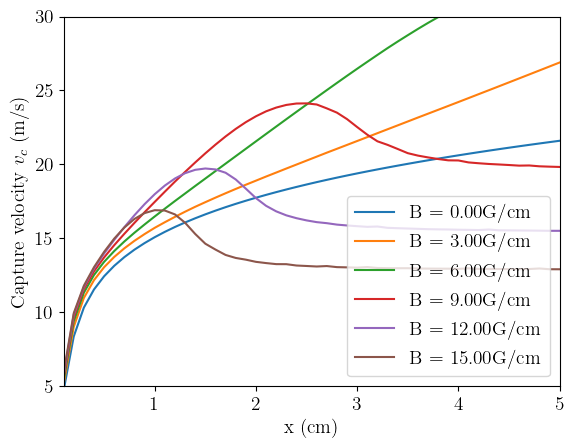

In [93]:
for i in range(6):
    plt.plot(beamdiams*100, res[:,i],label= f'B = {mags[i]*100:.2f}G/cm')
    plt.xlabel("x (cm)")
    plt.ylabel(r"Capture velocity $v_c$ (m/s)")
plt.ylim(5, 30)
plt.xlim(0.1, 5)
plt.legend()
plt.savefig('Figures/capvelfullintegral.svg', format='svg')

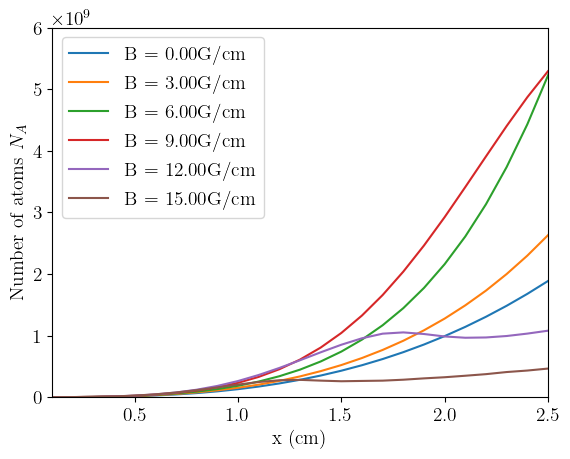

In [94]:
# Varying Magnetic Field Gradient
beamdiams = np.linspace(0.001, 0.1, 100)
mags = np.linspace(0, 0.15, 6)
res = np.zeros((100, 10))
output_x = np.zeros((1000, 1000))
output_y = np.zeros((1000, 1000))

for i in range(len(mags)):
    for k in range(len(beamdiams)):
        capture_velocity = cap_vel(beamdiams[k], 10, 8e6*2*np.pi, mags[i])
        res[k, i] = capture_velocity[0]

#B = 0 for comparison 
B0v = np.linspace(0, 20, 1000)
B0x = dx(B0v, 8e6*2*cons.pi, 10)

for i in range(6):
    na = (4*cons.pi*beamdiams**2/(8*collision_cs)) * (res[:,i] / velocity_rms)**4
    plt.plot(beamdiams*100, na,label= f'B = {mags[i]*100:.2f}G/cm')
    plt.xlabel("x (cm)")
    plt.ylabel(r"Number of atoms $N_A$")
plt.ylim(0.1, .6e10)
plt.xlim(0.1, 2.5)
plt.legend()
plt.savefig('Figures/multiplot1.svg', format='svg')

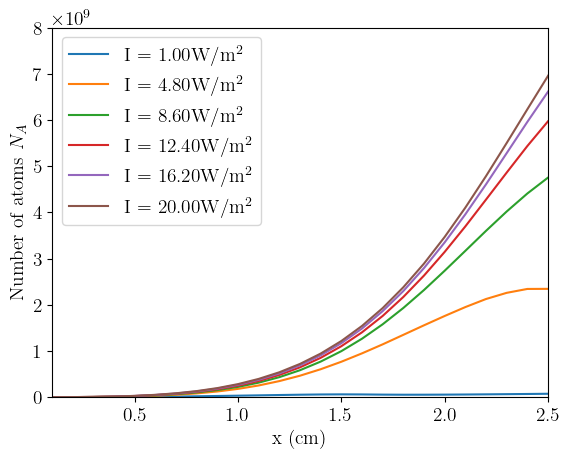

In [95]:
# Varying Intensity
beamdiams = np.linspace(0.001, 0.1, 100)
ints = np.linspace(1, 20, 6)
res = np.zeros((100, 10))
output_x = np.zeros((1000, 1000))
output_y = np.zeros((1000, 1000))

for i in range(len(ints)):
    for k in range(len(beamdiams)):
        capture_velocity = cap_vel(beamdiams[k], ints[i], 8e6*2*np.pi, 0.09)
        res[k, i] = capture_velocity[0]

#B = 0 for comparison 
B0v = np.linspace(0, 20, 1000)
B0x = dx(B0v, 8e6*2*cons.pi, 10)

for i in range(6):
    na = (4*cons.pi*beamdiams**2/(8*collision_cs)) * (res[:,i] / velocity_rms)**4
    plt.plot(beamdiams*100, na,label= f'I = {ints[i]:.2f}W/m$^2$')
    plt.xlabel("x (cm)")
    plt.ylabel(r"Number of atoms $N_A$")
plt.ylim(0.1, .8e10)
plt.xlim(0.1, 2.5)
plt.legend()
plt.savefig('Figures/multiplot2.svg', format='svg')

In [96]:
def cap_velo(x_0, beam_intensity, detuning, B):
    v_0 = 0.01
    S_0 = (x_0, v_0)
    t = np.linspace(0.15, 0, 10000) #was 1 and 0.2 adn 0.03 before
    t_span=[t[0], t[-1]]
    sol = sp.integrate.solve_ivp(dadt, t_span, S_0, t_eval = t, args=(beam_intensity, detuning, B), method='RK23') # args = (beam_intensity, detuning, B)
    f_linear = sp.interpolate.interp1d(sol.y[0,:],sol.y[1,:]) 
    return [f_linear(-x_0), sol]
    #return np.interp(-x_0, sol.y[0,:], sol.y[1,:])

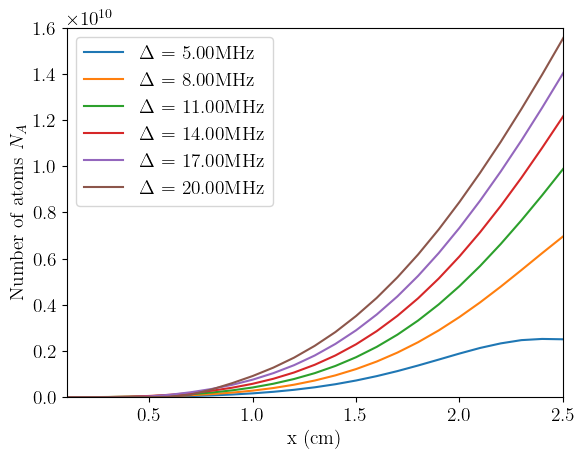

In [97]:
# Varying Detuning
beamdiams = np.linspace(0.001, 0.1, 100)
detuns = np.linspace(5e6, 20e6, 6)
res = np.zeros((100, 10))
output_x = np.zeros((1000, 1000))
output_y = np.zeros((1000, 1000))

for i in range(len(detuns)):
    for k in range(len(beamdiams)):
        capture_velocity = cap_velo(beamdiams[k], 20, detuns[i]*2*np.pi, 0.09)
        res[k, i] = capture_velocity[0]

for i in range(6):
    na = (4*cons.pi*beamdiams**2/(8*collision_cs)) * (res[:,i] / velocity_rms)**4
    plt.plot(beamdiams*100, na,label= f'$\Delta$ = {detuns[i]*1e-6:.2f}MHz')
    plt.xlabel("x (cm)")
    plt.ylabel(r"Number of atoms $N_A$")
plt.ylim(0.1, 1.6e10)
plt.xlim(0.1, 2.5)
plt.legend()
plt.savefig('Figures/multiplot3.svg', format='svg')

In [98]:
# Numerical Integration Optical Molasses w/ ODE (includes mag grad)
x_om, y_om = ODE(10, 2*np.pi*8e6, .1)

(0.0, 20.0)

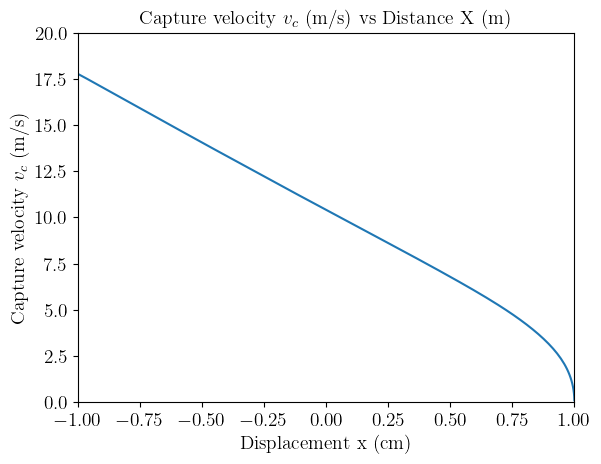

In [99]:
#FIG: Capture velocity vs Displacement w/ ODE
plt.figure(4)
plt.plot(x_om*100, y_om)
#plt.plot(result_ODE)
plt.ylabel("Capture velocity $v_c$ (m/s)")
plt.xlabel("Displacement x (cm)")
plt.title("Capture velocity $v_c$ (m/s) vs Distance X (m)")
plt.xlim(-1, 1)
plt.ylim(0,20)


(0.0, 20.0)

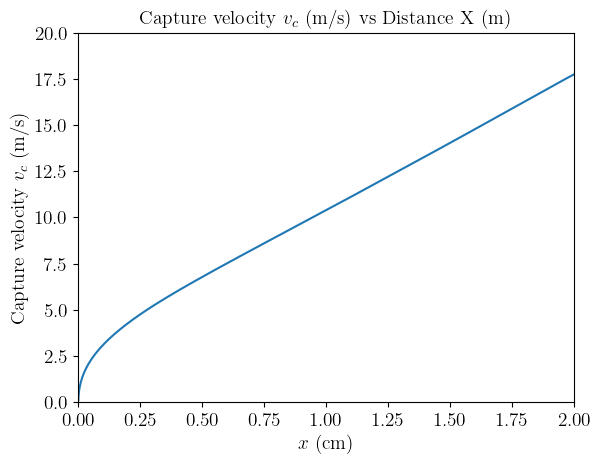

In [100]:
#FIG: Capture velocity vs Displacement w/ ODE axis starting at origin
plt.figure(4)
plt.plot(-x_om*100+1, y_om)
#plt.plot(result_ODE)
plt.ylabel("Capture velocity $v_c$ (m/s)")
plt.xlabel("$x$ (cm)")
plt.title("Capture velocity $v_c$ (m/s) vs Distance X (m)")
plt.xlim(0, 2)
plt.ylim(0,20)

Function to calculate the $v_c$ for a given detuning array $\Delta$

In [101]:
#Function to get vc from varying detuning
detunings = np.linspace(0, 100, 200)*1e6 # IN HERTZ
res_detuning = np.zeros((200))

def detuning_func(beam_intensity, detuning, B):
    x_0 = 0.01
    v_0 = 0.1
    S_0 = (x_0, v_0)
    t = np.linspace(.2, 0, 10000)
    t_span=[t[0], t[-1]]
    sol = sp.integrate.solve_ivp(dadt, t_span, S_0, t_eval = t, args=(beam_intensity, detuning*2*cons.pi, B), method='RK23') # args = (beam_intensity, detuning, B)
    f_linear_det = sp.interpolate.interp1d(sol.y[0,:],sol.y[1,:]) 
    return f_linear_det(-x_0)

for i in range(len(detunings)):
    res_detuning[i] = detuning_func(10, detunings[i], 0)

Maximum velocity at detuning of 13.57MHz with 16.94m/s


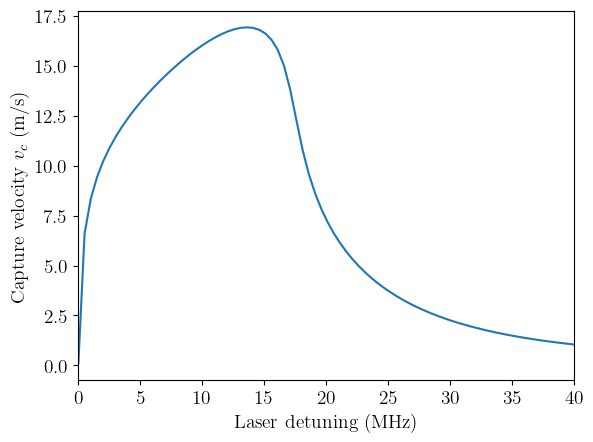

In [102]:
#Plot of Detuning vs Capture velocity
f_linear_detuning_vc = sp.interpolate.interp1d(res_detuning, detunings) 
plt.plot(detunings/1e6, res_detuning)
plt.xlabel(2)
plt.xlabel("Laser detuning (MHz)")
plt.ylabel("Capture velocity $v_c$ (m/s)")
plt.xlim(0, 40)
max_det = f_linear_detuning_vc(max(res_detuning))/1e6
print(f'Maximum velocity at detuning of {max_det:.2f}MHz with {max(res_detuning):.2f}m/s')
plt.savefig('Figures/capveldetuning.svg', format='svg')

Maximum number of atoms at detuning of 13.57MHz with 2.06*10^8 atoms


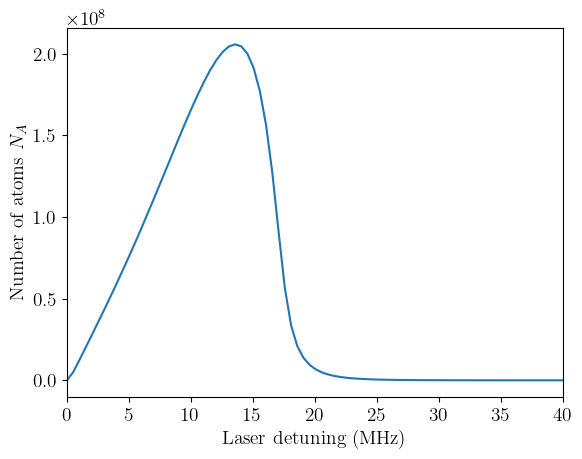

In [103]:
#Plot of Detuning vs Number of Atoms
no_atoms_det = (4*cons.pi*0.01**2/(8*collision_cs)) * (res_detuning / velocity_rms)**4
f_linear_detuning_na = sp.interpolate.interp1d(no_atoms_det, detunings) 
plt.plot(detunings/1e6, no_atoms_det)
plt.xlabel(2)
plt.xlabel("Laser detuning (MHz)")
plt.ylabel("Number of atoms $N_A$")
plt.xlim(0, 40)
max_det = f_linear_detuning_na(max(no_atoms_det))/1e6
print(f'Maximum number of atoms at detuning of {max_det:.2f}MHz with {max(no_atoms_det)/1e8:.2f}*10^8 atoms')
plt.savefig('Figures/detuningNA.svg', format='svg')

Function to calculate $v_c$ for a given intensity $I$

In [104]:
#Function to get vc from varying intensity
detuning = 8e6 # IN HERTZ
intensities = np.linspace(0, 100, 1000) #W/m^2 
res_intensity = np.zeros((1000))

def detuning_func(beam_intensity, detuning, B):
    x_0 = 0.01
    v_0 = 0.1
    S_0 = (x_0, v_0)
    t = np.linspace(.2, 0, 1000)
    t_span=[t[0], t[-1]]
    sol = sp.integrate.solve_ivp(dadt, t_span, S_0, t_eval = t, args=(beam_intensity, detuning*2*cons.pi, B), method='RK23') # args = (beam_intensity, detuning, B)
    f_linear_det = sp.interpolate.interp1d(sol.y[0,:],sol.y[1,:]) 
    return f_linear_det(-x_0)

for i in range(len(intensities)):
    res_intensity[i] = detuning_func(intensities[i], 8e6, 0.1)

Maximum velocity at intensity of 48.35W/m2 with 19.01m/s


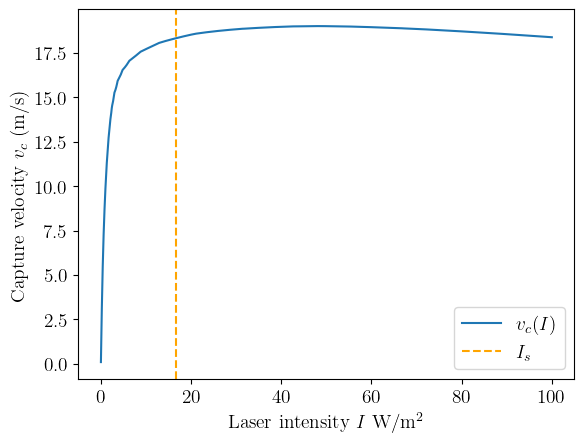

In [105]:
#Plot of Intensity vs Capture velocity

f_linear_intensity_vc = sp.interpolate.interp1d(res_intensity, intensities) 
max_int = f_linear_intensity_vc(max(res_intensity))
sat_intensity_array = np.array(sat_intensity)*np.ones(100)
plt.plot(intensities, res_intensity, label=r"$v_c(I)$")
#plt.plot(sat_intensity_array, "--", label=r"$I_s$")
plt.axvline(x = 16.68, color = 'orange', label = '$I_s$', linestyle="--")
plt.xlabel(2)
plt.xlabel(r"Laser intensity $I$ W/m$^2$")
plt.ylabel(r"Capture velocity $v_c$ (m/s)")
plt.legend()
print(f'Maximum velocity at intensity of {max_int:.2f}W/m2 with {max(res_intensity):.2f}m/s')
plt.savefig('Figures/vcintensity.svg', format='svg')

Maximum number of atoms at intensity of 48.35W/m2 with 3.26x10^8 Atoms


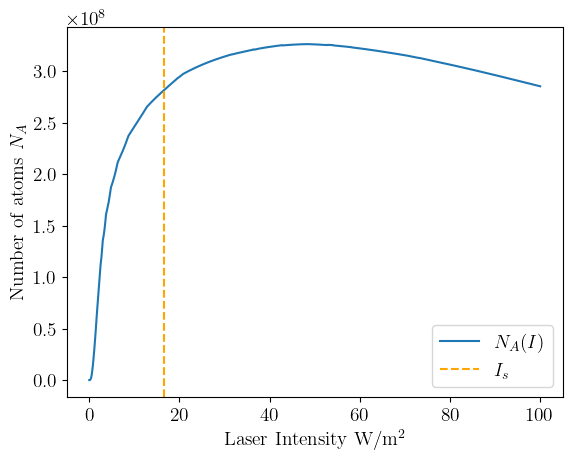

In [106]:
#Plot of Intensity vs Number of atoms
no_atoms_int = (4*cons.pi*beam_radious**2/(8*collision_cs)) * (res_intensity / velocity_rms)**4
f_linear_intensity_vc = sp.interpolate.interp1d(no_atoms_int, intensities) 
max_int = f_linear_intensity_vc(max(no_atoms_int))
plt.plot(intensities, no_atoms_int, label=r"$N_A(I)$")
plt.axvline(x = 16.68, color = 'orange', label = '$I_s$', linestyle="--")
plt.xlabel(r"Laser Intensity W/m$^2$")
plt.ylabel(r"Number of atoms $N_A$")
plt.legend()
print(f'Maximum number of atoms at intensity of {max_int:.2f}W/m2 with {max(no_atoms_int/1e8):.2f}x10^8 Atoms')
plt.savefig('Figures/intensity2.svg', format='svg')

In [107]:
# Function to vary Capture velocity with Intensity
# Using DX function
beam_intensity = np.linspace(0, 100, 100)
v_i = np.linspace(0, 40, 100)
R_i = np.array([])
for i in beam_intensity:
    result = np.interp(0.02, dx(v_i, 8e6*2*cons.pi, i), v_i)
    R_i = np.append(result, R_i)

Na_intensity = (area/(8*collision_cs)) * (R_i / velocity_rms)**4

C:\Users\Richa\AppData\Local\Temp\ipykernel_24428\1598160317.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  res = lambda vA: vA/((cons.hbar * wavenumber * decay_d2rb87 * 0.5)/(mass_rb87) * (((beam_intensity / sat_intensity)/(1 + beams*(beam_intensity / sat_intensity) + ((2*detuning - 2* wavenumber * vA)/decay_d2rb87)**2)) - (((beam_intensity / sat_intensity)/(1 + beams*(beam_intensity / sat_intensity) + ((2*detuning + 2* wavenumber * vA)/decay_d2rb87)**2)))))
C:\Users\Richa\AppData\Local\Temp\ipykernel_24428\1598160317.py:8: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  y, err = sp.integrate.quad(res, 1, val)


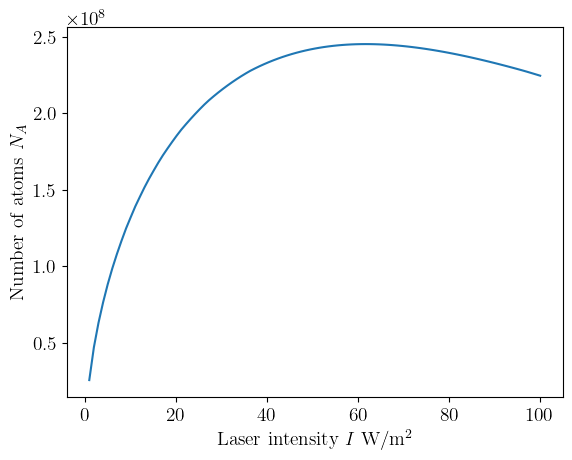

In [108]:
#FIG: Intensity vs No_atoms using normal integration 
plt.plot(beam_intensity, Na_intensity[::-1])
plt.xlabel("Laser intensity $I$ W/m$^2$")
plt.ylabel("Number of atoms $N_A$")
plt.savefig('Figures/intensity.svg', format='svg')

In [109]:
# Number of Atoms Trapped w/ dx function (B = 0)
v_no = np.linspace(0, 20, 10000)
x_no = dx(v_no, 8e6*2*cons.pi, 10)
no_atoms = (4*cons.pi*x_no**2/(8*collision_cs)) * (v_no / velocity_rms)**4


Text(0, 0.5, 'Number of atoms $N_A$')

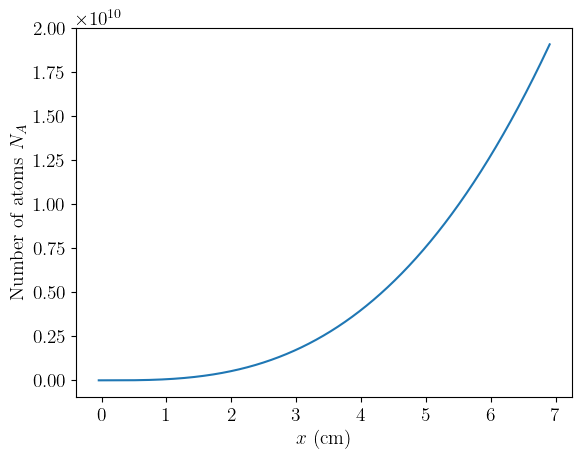

In [110]:
# Capture velocity vs no of atoms 
plt.figure(7)
plt.plot(x_no*100, no_atoms)
plt.xlabel("$x$ (cm)")
plt.ylabel("Number of atoms $N_A$")
#plt.title("Atom velocity V (m/s) vs Number of Atoms")

Number of Atoms $N_A$ as beam diameter changes w/ B = 0.1T

In [111]:
beamdiams = np.linspace(0.001, 0.05, 100)
mags = np.linspace(0, .5, 10)
res = np.zeros((100, 10))
output_x = np.zeros((1000, 1000))
output_y = np.zeros((1000, 1000))

for i in range(len(mags)):
    for k in range(len(beamdiams)):
        capture_velocity = cap_vel(beamdiams[k], 10, 8e6*2*np.pi, mags[i])
        res[k, i] = capture_velocity[0]


#B = 0 for comparison 
B0v = np.linspace(0, 20, 1000)
B0x = dx(B0v, 8e6*2*cons.pi, 10)

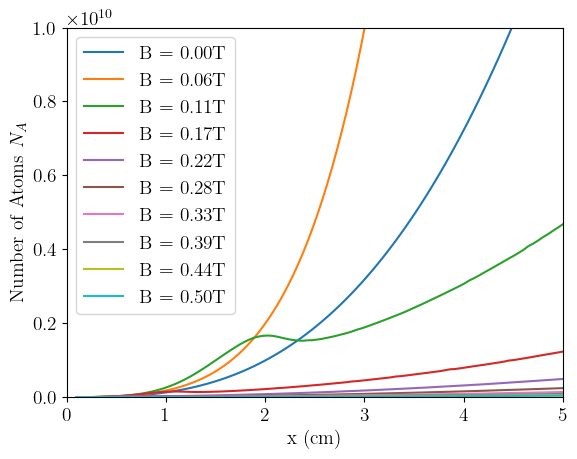

In [112]:
no_atoms_ode = np.zeros((10, 100))
for i in range(10):
    no_atoms_ode[i] = (4*cons.pi*beamdiams**2/(8*collision_cs)) * (res[:,i] / velocity_rms)**4
    plt.plot(beamdiams*100, no_atoms_ode[i] ,label= f'B = {mags[i]:.2f}T')
    plt.xlabel("x (cm)")
    plt.ylabel(r"Number of Atoms $N_A$")
plt.ylim(0, 1e10)
plt.xlim(0, 5)
plt.legend()

Change in $v_c$ as $B$ changes 

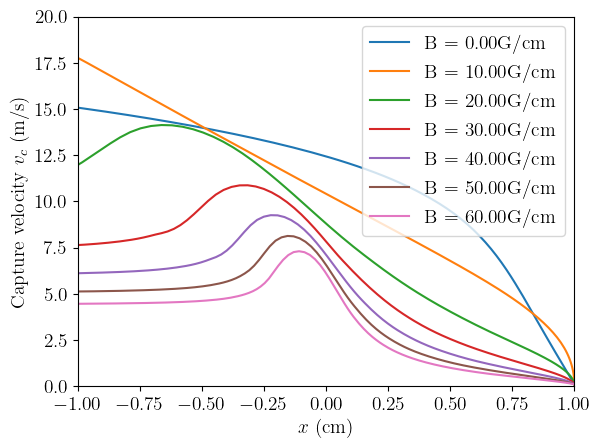

In [113]:
detuning = 2*cons.pi * 8e6
x_0 = 0.01
v_0 = 0.1
S_0 = (x_0, v_0)
t = np.linspace(0.03, 0, 1000)
#t_span = (0, 0.01)
t_span=[t[0], t[-1]]
#B = np.array([0, 0.05, 0.1, 0.15, 0.20, 0.25, 0.5, 1])
B = np.linspace(0, .6, 7)
for i in B:
    #B = i 
    sol = sp.integrate.solve_ivp(dadt, t_span, S_0, t_eval = t, args=(10, detuning, i), method='RK45') # args = (beam_intensity, detuning, B)
    plt.plot(sol.y[0,:]*100,sol.y[1,:],label= f'B = {i*100:.2f}G/cm')
    # plt.plot(sol.t, sol.y[1,:])
plt.xlim(-1, 1)
plt.ylim(0,20)
plt.ylabel(r"Capture velocity $v_c$ (m/s)")
plt.xlabel("$x$ (cm)")
#plt.title(r"Capture velocity $v_c$ (m/s) vs Distance x (cm)")
plt.legend()
# plt.show()
plt.savefig('Figures/vcB.svg', format='svg')

Function to find $N_A$ to be optimised 

In [114]:
def N_A(x_0, beam_intensity, detuning, B):
    v_0 = 0.1
    S_0 = (x_0, v_0)
    t = np.linspace(.5, 0, 10000) #was 1 and 0.2 adn 0.03 before
    t_span=[t[0], t[-1]]
    sol = sp.integrate.solve_ivp(dadt, t_span, S_0, t_eval = t, args=(beam_intensity, detuning, B), method='RK23') # args = (beam_intensity, detuning, B)
    f_linear = sp.interpolate.interp1d(sol.y[0,:],sol.y[1,:])
    number_atoms = (4*cons.pi*x_0**2/(8*collision_cs)) * (f_linear(-x_0) / velocity_rms)**4
    return number_atoms
    #return [sol.y[0,:], sol.y[1,:]]

In [115]:
beam_diam = np.linspace(0.001, 0.1, 100)
mags = np.linspace(0, 0.15, 6)
rr = np.zeros((100, 10))
for i in range(len(mags)):
    for k in range(len(beam_diam)):
        no_atoms = N_A(beam_diam[k], 10, 8e6*2*np.pi, mags[i])
        rr[k, i] = no_atoms

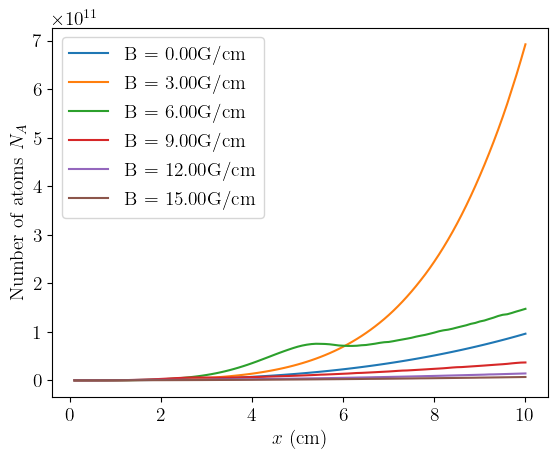

In [116]:
for j in range(6):
    plt.plot(beam_diam*100, rr[:,j],label= f'B = {mags[j]*100:.2f}G/cm')
    plt.xlabel("x (cm)")
    plt.ylabel(r"$v_c$ (m/s)")
    plt.xlabel("$x$ (cm)")
    plt.ylabel(r"Number of atoms $N_A$")
    plt.legend()
plt.savefig('Figures/noatoms_B_big.svg', format='svg')

Find $N_A$ of Rubidium 87 trap with the N_A function and the following trap parameters:
 - N_A(Beam Diameter, Intensity, Detuning, Magnetic Field Gradient)

In [117]:
N_A(0.01, 10, 8e6*2*np.pi, 0.1)

247540774.20812368